# Heart Attack Analysis - initial model training

## Task

The goal is to train predictive models for a selected ML problem. Compare their performance with a relevant measure.
Submit knitr/notebook script to GitHub (directory `Homeworks/HW1/FirstnameLastname`).

- use any of the datasets listed in `Datasets`, note that some of them are linked with `classification` and other with `regression` problems
- train 2-3 models with different structures (logistic regression, boosting, random forest or other) and evaluate their performance on this dataset (use train/test split or some other evaluation strategy)
- carry out analyses in jupiter notebooks or Rmd (markdown) scripts
- upload a reproducible script together with the final results on GitHub. I remember that the result is not just a code, this one can be automatically generated. The results must be properly commented. 

In [1]:
# Download the dataset
!gdown --id 1NZWMlrVLLFcpeUxIUK8b5gG3DZ0qN3C2
!unzip heart_attack.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NZWMlrVLLFcpeUxIUK8b5gG3DZ0qN3C2
To: /content/heart_attack.zip
100% 4.21k/4.21k [00:00<00:00, 3.83MB/s]
Archive:  heart_attack.zip
  inflating: heart.csv               
  inflating: o2Saturation.csv        


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import plot_roc_curve

# Initial eyeballing over the data

We look at total number of examples (303) and also investigate balance of positive/negative class.

In [5]:
ds = pd.read_csv('heart.csv')
print('Number of examples: ', len(ds))
ds.head()

Number of examples:  303


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Class balance

We can see that classes are pretty balanced so we don't have to apply any specific techniques for that

In [6]:
ds.output.value_counts()

1    165
0    138
Name: output, dtype: int64

# Variables description

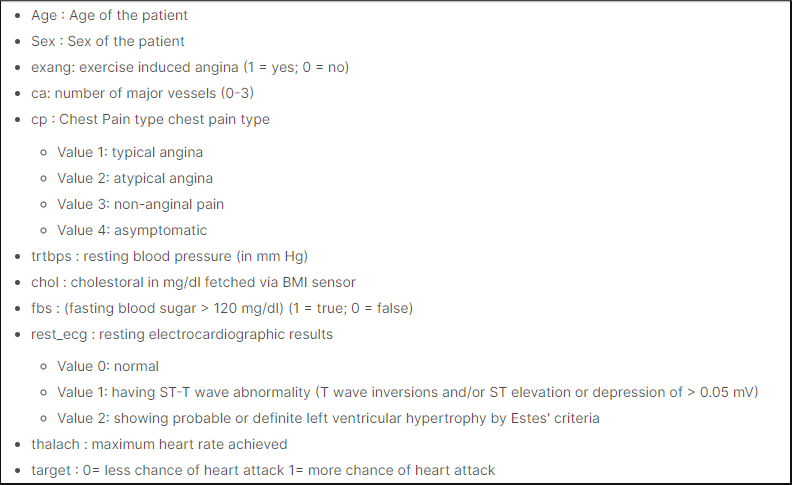

# Data preprocessing

We apply log transform to the numerical variables (so that they are more friendly for logistic regression-type models) and one-hot encoding for categorical variables.

In [7]:
continuous_cols = ['age', 'chol','oldpeak', 'thalachh', 'trtbps']
categorical_cols = ['cp', 'restecg']

def categoricalize(df, columns):
    for col in columns:
        dummy_values = pd.get_dummies(df[col])
        for v in dummy_values.columns:
            df = pd.concat([df, dummy_values[v].rename(f'{col}__{v}')], axis=1)
    return df.drop(columns=columns)

processed_ds = categoricalize(ds, categorical_cols)

for col in continuous_cols:
    processed_ds[col] = np.log1p(ds[col])

x, y = processed_ds.drop(columns=['output']), processed_ds['output']

x_train, x_test, y_train, y_test=train_test_split(x, y,
                                               test_size=0.2,
                                               random_state=2139) 


train_ds = x_train
test_ds = x_test

# Metrics

For the binary classification we measure the following metrics:


*   Accuracy
*   Precision
*   Recall
*   F1
*   MSE

and also plot the confusion matrix



In [9]:
def compute_metrics(y_pred, y_gt):
    cm=confusion_matrix(y_gt, y_pred)
    class_label = ["Low-risk", "High-risk"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm,annot=True,cmap='Pastel1',linewidths=2,fmt='d')
    plt.title("Confusion Matrix",fontsize=15)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

    acc=accuracy_score(y_gt,y_pred)
    mse=mean_squared_error(y_gt,y_pred)
    precision, recall, fscore, train_support = score(y_gt, y_pred, pos_label=1, average='binary')
    print('Precision: {} \nRecall: {} \nF1: {} \nAccuracy: {} %\nMSE: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore,3), round((acc*100),3), round((mse),3)))

def evaluate_model(model):
    model.fit(train_ds, y_train)
    y_pred = model.predict(test_ds)

    compute_metrics(y_pred, y_test)
    plot_roc_curve(model, test_ds, y_test)

# Model evaluation

# 1. Random forest

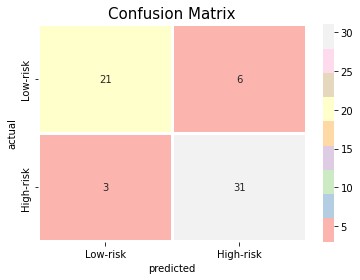

Precision: 0.838 
Recall: 0.912 
F1: 0.873 
Accuracy: 85.246 %
MSE: 0.148


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


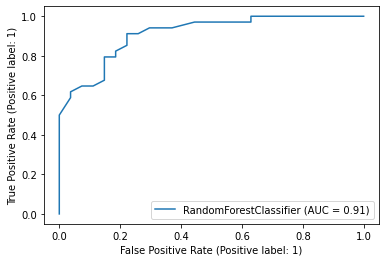

In [10]:
rf_classifier = RandomForestClassifier(random_state=69)
evaluate_model(rf_classifier)

### Comment 

We see that the model tends to be oversensitive - predicts high-risk for a significant fraction of low-risk patients, but low-risk for a smaller number of actually high-risk patients, which is good from out perspective. The ROC curve
shows that for a small fraction of low-risk patients (around 20%) we predict pretty high scores comparing to the high-risk patients, but at least 50% of the high-risk patients have better score than any positive low-risk patient.

# 2. Logistic regression

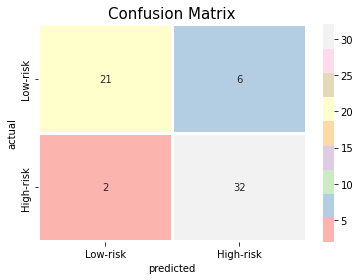

Precision: 0.842 
Recall: 0.941 
F1: 0.889 
Accuracy: 86.885 %
MSE: 0.131


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


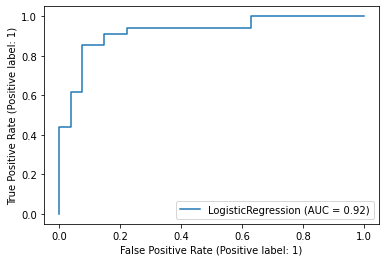

In [11]:
logistic_reg = LogisticRegression(random_state=69, max_iter=1000)
evaluate_model(logistic_reg)

## Comment 
Logistic regression performs similarly well, comparing to the random forest model - 1% improvement in accuracy, AUC and F1. It has the same number of false positives and one less true negative. The ROC curve shows that for more than 80% of true examples, their scores are higher than most of the false examples. 

# 3. Decision tree

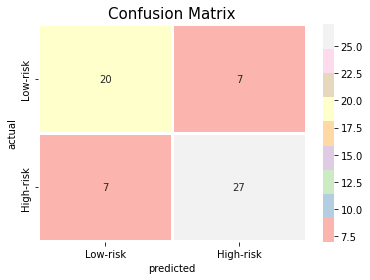

Precision: 0.794 
Recall: 0.794 
F1: 0.794 
Accuracy: 77.049 %
MSE: 0.23


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


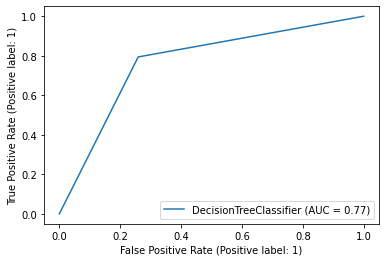

In [13]:
decision_tree = DecisionTreeClassifier(random_state=69)
evaluate_model(decision_tree)

## Comment
We expected the decision tree model not to perform very well and only serve as a baseline. From the ROC curve we see that top1 scoring example is already a false positive which is concerning, and we need to predict about 30% false positives to get a recall of 0.8. 

# Comments on the confusion matrix plots

For better performing models (logistic regression, random forest) we see that they have worse precision than recall, so they are slightly over-sensitive. The decision tree model has the same precision and recall. 



# Summary

We applied basic data preprocessing and compared 3 simple models - the best one turns out to be logistic regression, but random forest is pretty close.


All metrics we measured have similar trend (are very correlated). 